<a href="https://colab.research.google.com/github/iqbalhanif/NN-with-Keras/blob/master/stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import important packages
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
import math

In [ ]:
#get data
!wget https://raw.githubusercontent.com/yumoxu/stocknet-dataset/master/price/raw/AAPL.csv

--2020-09-09 15:33:10--  https://raw.githubusercontent.com/yumoxu/stocknet-dataset/master/price/raw/AAPL.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91531 (89K) [text/plain]
Saving to: ‘AAPL.csv’

AAPL.csv            100%[===================>]  89.39K  --.-KB/s    in 0.03s   

2020-09-09 15:33:10 (2.84 MB/s) - ‘AAPL.csv’ saved [91531/91531]



In [ ]:
#convert data to pandas dataframe
df = pd.read_csv('AAPL.csv')
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500


In [ ]:
df.shape

(1258, 7)

In [ ]:
#cek null
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
#split train and val
train = math.ceil(80 / 100 * 1258)
train

251

In [ ]:
val  = math.floor(20 /100 * 1258)
val

251

In [ ]:
df_train = df.iloc[0:train, :]
df_val = df.iloc[train:1258,:]
df_val.shape

(251, 7)

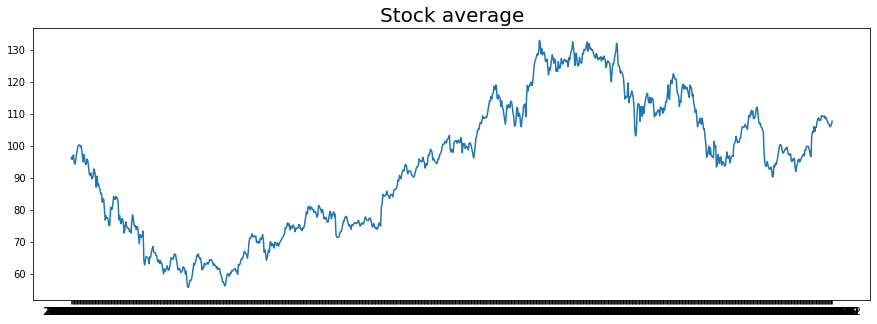

In [ ]:
#eda train
dates_train = df_train['Date'].values
close_train = df_train['Close'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates_train, close_train)
plt.title('Stock average',
          fontsize=20);

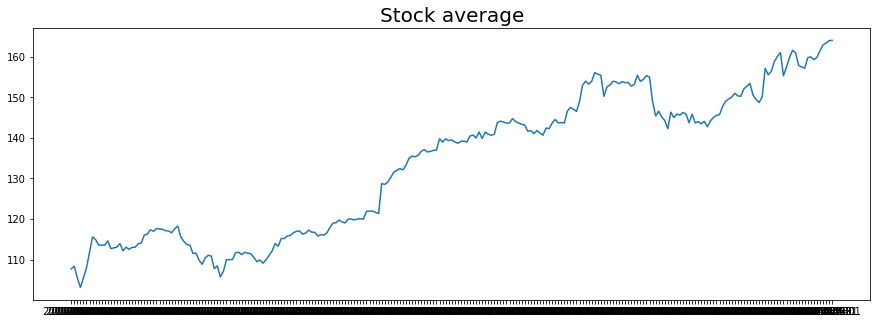

In [ ]:
#eda val
dates_val = df_val['Date'].values
close_val = df_val['Close'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates_val, close_val)
plt.title('Stock average',
          fontsize=20);

In [ ]:
#data transform
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
train_set = windowed_dataset(close_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(close_val, window_size=60, batch_size=100, shuffle_buffer=1000)

In [ ]:
#Arsitektur NN
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(100, return_sequences=True),
  tf.keras.layers.LSTM(100),
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dense(25, activation="relu"),
  tf.keras.layers.Dense(1),
])
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
#modeling
history = model.fit(train_set,epochs=100, validation_data=val_set)

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 3s 277ms/step - loss: 93.2838 - mae: 93.7838 - val_loss: 133.0625 - val_mae: 133.5625
Epoch 2/100
10/10 [==============================] - 2s 214ms/step - loss: 93.0265 - mae: 93.5265 - val_loss: 132.8033 - val_mae: 133.3033
Epoch 3/100
10/10 [==============================] - 2s 210ms/step - loss: 92.7839 - mae: 93.2839 - val_loss: 132.6051 - val_mae: 133.1051
Epoch 4/100
10/10 [==============================] - 2s 209ms/step - loss: 92.5895 - mae: 9

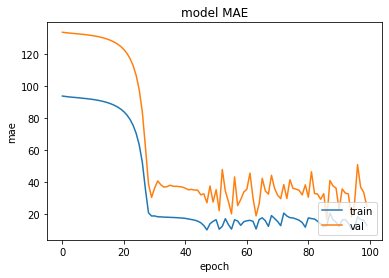

In [ ]:
#plot mae
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

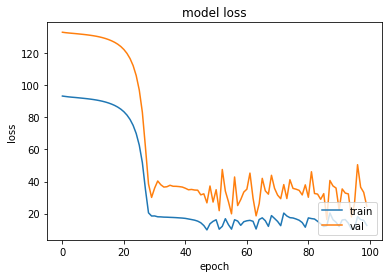

In [ ]:
#plot mae
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()